In [2]:
import os
import cv2
from cv2 import rectangle
import pydicom
from pydicom.data import get_testdata_files
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from skimage.transform import resize
from keras.layers import Dense, Conv2D
from keras import Model
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
import seaborn as sns

In [3]:
PathDicom = "C:/Users/Lenovo-pc/Python_practice/Project_Pneumonia/rsna-pneumonia-detection-challenge/stage_2_train_images/"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(PathDicom):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
                #print(filename)
            lstFilesDCM.append(os.path.join(dirName,filename))

In [4]:
len(lstFilesDCM)

26684

In [5]:
print(lstFilesDCM[0])

C:/Users/Lenovo-pc/Python_practice/Project_Pneumonia/rsna-pneumonia-detection-challenge/stage_2_train_images/0004cfab-14fd-4e49-80ba-63a80b6bddd6.dcm


# EDA

### The target class information has been taken from stage_2_detailed_class_info.csv. A new number column has been added to the csv with a numeric value corresponding to each class i.e. 0 for Normal, 1 for Lung Opacity and 2 for No Lung Opacity / Not Normal.

In [6]:
pat_class=pd.read_csv('C:/Users/Lenovo-pc/Python_practice/Project_Pneumonia/rsna-pneumonia-detection-challenge/stage_2_detailed_class_info.csv')
pat_class.head()

,patientId,class,classflag
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,0
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,1


In [7]:
pat_class_grp=pat_class.groupby("patientId", axis=0, sort=True).last().classflag

In [8]:
len(pat_class_grp)

26684

In [9]:
pat_class_grp.head()

patientId
0004cfab-14fd-4e49-80ba-63a80b6bddd6    2
000924cf-0f8d-42bd-9158-1af53881a557    0
000db696-cf54-4385-b10b-6b16fbb3f985    1
000fe35a-2649-43d4-b027-e67796d412e0    1
001031d9-f904-4a23-b3e5-2c088acd19c6    1
Name: classflag, dtype: int64

In [10]:
pat_age_sex_class={}
for row in lstFilesDCM:
    data=pydicom.read_file(row)
    pat_age_sex_class[data.PatientID]={'age':data.PatientAge, 'sex':data.PatientSex, 'class':pat_class_grp.loc[data.PatientID]}   

In [11]:
pat_age_sex_class['0004cfab-14fd-4e49-80ba-63a80b6bddd6']

{'age': '51', 'sex': 'F', 'class': 2}

In [12]:
df_data=pd.DataFrame.from_dict(pat_age_sex_class, orient='index').reset_index()

In [13]:
df_data.columns=(['patientId','age','sex','class'])

In [14]:
df_data.head()

,patientId,age,sex,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F,2
1,000924cf-0f8d-42bd-9158-1af53881a557,19,F,0
2,000db696-cf54-4385-b10b-6b16fbb3f985,25,F,1
3,000fe35a-2649-43d4-b027-e67796d412e0,40,M,1
4,001031d9-f904-4a23-b3e5-2c088acd19c6,57,M,1


In [15]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 4 columns):
patientId    26684 non-null object
age          26684 non-null object
sex          26684 non-null object
class        26684 non-null int64
dtypes: int64(1), object(3)
memory usage: 834.0+ KB


### Converting Age to int

In [16]:
df_data['age']=df_data['age'].apply(int)

In [17]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26684 entries, 0 to 26683
Data columns (total 4 columns):
patientId    26684 non-null object
age          26684 non-null int64
sex          26684 non-null object
class        26684 non-null int64
dtypes: int64(2), object(2)
memory usage: 834.0+ KB


In [18]:
df_data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,26684,26684,8f1ebcac-42fc-458b-9f4d-c678698c3bdc,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,26684,NaN,NaN,NaN,47.03,16.8106,1,34,49,59,155
sex,26684,2,M,15166,NaN,NaN,NaN,NaN,NaN,NaN,NaN
class,26684,NaN,NaN,NaN,1.1113,0.873119,0,0,1,2,2


In [19]:
df_data['sex'].value_counts()

M    15166
F    11518
Name: sex, dtype: int64

### Applying One Hot Encoding to the attribute Sex 

In [20]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df_data['sex']=le.fit_transform(df_data['sex'])

In [21]:
df_data['sex'].value_counts()

1    15166
0    11518
Name: sex, dtype: int64

In [22]:
df_data.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
patientId,26684,26684,8f1ebcac-42fc-458b-9f4d-c678698c3bdc,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,26684,NaN,NaN,NaN,47.03,16.8106,1,34,49,59,155
sex,26684,NaN,NaN,NaN,0.568356,0.495315,0,0,1,1,1
class,26684,NaN,NaN,NaN,1.1113,0.873119,0,0,1,2,2


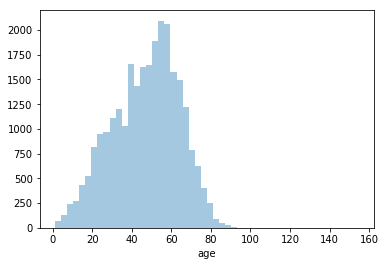

In [23]:
import seaborn as sns
sns.distplot(df_data['age'],kde=False)

## The attribute age looks to be almost normally distributed with median age of 49. Most of the patients are in the age range of 20-70.The min and max values of 0 and 155 indicate presence of outliers.

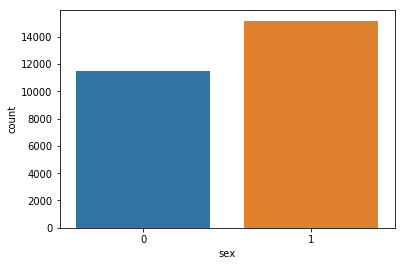

In [24]:
sns.countplot(df_data['sex'])

### The data distribution between the gender looks almost equal with samples for male patients slightly higher than female patients.

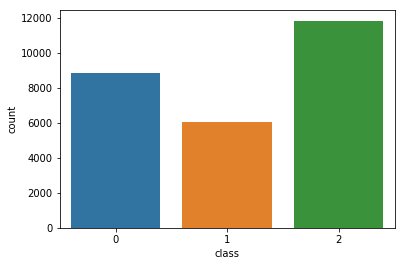

In [27]:
sns.countplot(df_data['class'])

In [28]:
df_data['class'].value_counts()

2    11821
0     8851
1     6012
Name: class, dtype: int64

## The target class of 2 i.e. No Lung Opacity / Not Normal is dominating the other 2 classes. There is a class imbalance which we may need to deal with later in the data prep stage.

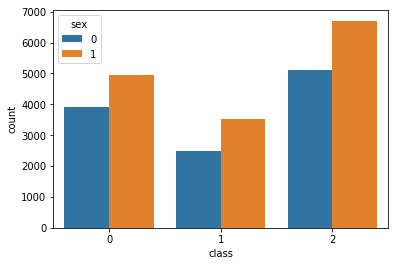

In [29]:
sns.countplot(x=df_data['class'],hue=df_data['sex'])

## The distribution of both genders looks almost proportional in all the 3 target classes.

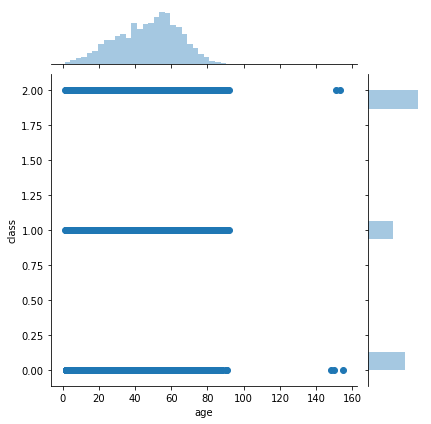

In [30]:
sns.jointplot(df_data['age'], df_data['class'])

## There does not seem any relationship between between age and target class. There are outliers in target class 0 and 2 with patients age between 140 and 160.

In [31]:
df_data.drop(columns=['patientId'],inplace=True)

In [32]:
df_data.head()

,age,sex,class
0,51,0,2
1,19,0,0
2,25,0,1
3,40,1,1
4,57,1,1


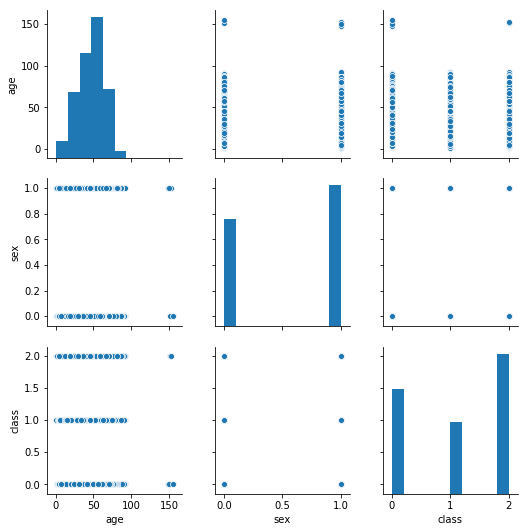

In [33]:
sns.pairplot(df_data)

In [34]:
corr=df_data.corr()

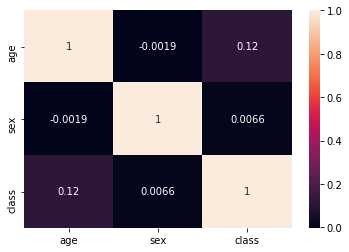

In [35]:
sns.heatmap(corr, annot=True)

In [36]:
def save_labels():
    labels = pd.read_csv('C:/Users/Lenovo-pc/Python_practice/Project_Pneumonia/rsna-pneumonia-detection-challenge/Train_images/stage_2_train_labels_orig.csv')
    #patset=[]
    patbbsetfin=[]
    patient_id=labels['patientId'].value_counts().index
    for pid in patient_id:
         patdtl=labels[labels['patientId']==pid]
         patbbset=[]
         for patrow in patdtl.iterrows():
             bbset=[]
             #print(patrow[1])
             bbset.append(patrow[1][1])
             bbset.append(patrow[1][2])
             bbset.append(patrow[1][3])
             bbset.append(patrow[1][4])
             patbbset.append(bbset) 
         patbbsetfin.append([pid, patbbset, patrow[1]['Target']])

    patbbsetfinarr=np.array(patbbsetfin)
    np.save('patient_labels.npy', patbbsetfinarr)        

In [37]:
newpatarr=np.load('patient_labels.npy')
dictpatient={}
dictbboxtarget={}
for row in newpatarr:
    j=0
    dictbbox={}
    for bbox in row[1]:
        i=0
        dictcoord={}
        for coord in bbox:
            if i==0:
                x=coord
            if i==1:
                y=coord
            if i==2:
                width=coord
            if i==3:
                height=coord
            i=i+1
        dictcoord={'x' : x, 'y' : y, 'width' : width, 'height' : height} 
        j=j+1    
        dictbbox[j]=dictcoord
    bbox=dictbbox    
    dictbboxtarget={'bbox':bbox, 'target':row[2]}
    dictpatient[row[0]]=dictbboxtarget

In [38]:
count_0=0
count_1=0
count_4_bb=0
count_3_bb=0
count_2_bb=0
count_1_bb=0
count_4_bb_fake=0
count_3_bb_fake=0
count_2_bb_fake=0
count_1_bb_fake=0
for k in dictpatient.keys():
    if dictpatient[k]['target'] == 0:
        count_0=count_0+1
        if len(dictpatient[k]['bbox'])==4:
            count_4_bb_fake=count_4_bb+1
        if len(dictpatient[k]['bbox'])==3:
            count_3_bb_fake=count_3_bb+1
        if len(dictpatient[k]['bbox'])==2:
            count_2_bb_fake=count_2_bb+1
        if len(dictpatient[k]['bbox'])==1:
            count_1_bb_fake=count_1_bb+1
            #print(dictpatient[k]['bbox'])
        
    else:    
        count_1=count_1+1
        
        if len(dictpatient[k]['bbox'])==4:
            count_4_bb=count_4_bb+1
        if len(dictpatient[k]['bbox'])==3:
            count_3_bb=count_3_bb+1
        if len(dictpatient[k]['bbox'])==2:
            count_2_bb=count_2_bb+1
        if len(dictpatient[k]['bbox'])==1:
            count_1_bb=count_1_bb+1
            


In [39]:
print(count_4_bb) # Count of patients with 4 bounding box

13


In [40]:
print(count_3_bb) # Count of patients with 3 bounding box

119


In [41]:
print(count_2_bb) # Count of patients with 1 bounding box

3266


In [42]:
print(count_1_bb) # Count of patients with 1 bounding box

2614


## Where target class = 1, patients with 2 bboxes are the most at 3266 followed by 1bbox at 2614. Patients with 3 and 4 bboxes are negligible at 119 and 13 respectively.

# EDA Section Complete

In [333]:
age_bracket_20=0
age_bracket_40=0
age_bracket_60=0
age_bracket_150=0

age_bracket_0_20=0
age_bracket_0_40=0
age_bracket_0_60=0
age_bracket_0_150=0

age_bracket_1_20=0
age_bracket_1_40=0
age_bracket_1_60=0
age_bracket_1_150=0

age_bracket_2_20=0
age_bracket_2_40=0
age_bracket_2_60=0
age_bracket_2_150=0

sex_m=0
sex_f=0
class_0=0
class_1=0
class_2=0
class_0_f=0
class_1_f=0
class_2_f=0
class_0_m=0
class_1_m=0
class_2_m=0

for i in pat_age_sex.values():
    if i['sex'] == 'F':
        sex_f=sex_f+1
    if i['sex'] == 'M': 
        sex_m=sex_m+1
    if (int(i['age']) <= 10):
        age_bracket_20=age_bracket_20+1
    if (int(i['age']) > 10 and int(i['age']) <= 40): 
        age_bracket_40=age_bracket_40+1
    if (int(i['age']) > 40 and int(i['age']) <= 60): 
        age_bracket_60=age_bracket_60+1
    if (int(i['age']) > 60 and int(i['age']) <= 150): 
        age_bracket_150=age_bracket_150+1
    if int(i['class']) == 0:
        class_0=class_0+1
        if i['sex'] == 'F':
            class_0_f=class_0_f+1
        if i['sex'] == 'M':    
            class_0_m=class_0_m+1
        if (int(i['age']) <= 10):
            age_bracket_0_20=age_bracket_0_20+1
        if (int(i['age']) > 10 and int(i['age']) <= 40): 
            age_bracket_0_40=age_bracket_0_40+1
        if (int(i['age']) > 40 and int(i['age']) <= 60): 
            age_bracket_0_60=age_bracket_0_60+1
        if (int(i['age']) > 60 and int(i['age']) <= 150): 
            age_bracket_0_150=age_bracket_0_150+1            
    if int(i['class']) == 1: 
        class_1=class_1+1
        if i['sex'] == 'F':
            class_1_f=class_1_f+1
        if i['sex'] == 'M':
            class_1_m=class_1_m+1
        if (int(i['age']) <= 10):
            age_bracket_1_20=age_bracket_1_20+1
        if (int(i['age']) > 10 and int(i['age']) <= 40): 
            age_bracket_1_40=age_bracket_1_40+1
        if (int(i['age']) > 40 and int(i['age']) <= 60): 
            age_bracket_1_60=age_bracket_1_60+1
        if (int(i['age']) > 60 and int(i['age']) <= 150): 
            age_bracket_1_150=age_bracket_1_150+1            
            
    if int(i['class']) == 2: 
        class_2=class_2+1
        if i['sex'] == 'F':
            class_2_f=class_2_f+1
        if i['sex'] == 'M':
            class_2_m=class_2_m+1
        if (int(i['age']) <= 10):
            age_bracket_2_20=age_bracket_2_20+1
        if (int(i['age']) > 10 and int(i['age']) <= 40): 
            age_bracket_2_40=age_bracket_2_40+1
        if (int(i['age']) > 40 and int(i['age']) <= 60): 
            age_bracket_2_60=age_bracket_2_60+1
        if (int(i['age']) > 60 and int(i['age']) <= 150): 
            age_bracket_2_150=age_bracket_2_150+1            

        
    #print(i['sex'])

In [312]:
print(sex_f)

11518


In [313]:
print(sex_m)

15166


In [315]:
print(age_bracket_20)

435


In [316]:
print(age_bracket_40)

8609


In [317]:
print(age_bracket_60)

11667


In [314]:
print(age_bracket_150)

5970


In [323]:
print(class_0)

8851


In [331]:
print(class_0_m)

4946


In [332]:
print(class_0_f)

3905


In [338]:
print(age_bracket_0_20)

162


In [339]:
print(age_bracket_0_40)

3194


In [340]:
print(age_bracket_0_60)

3907


In [341]:
print(age_bracket_0_150)

1587


In [324]:
print(class_1)

6012


In [330]:
print(class_1_m)

3510


In [329]:
print(class_1_f)

2502


In [342]:
print(age_bracket_1_20)

139


In [343]:
print(age_bracket_1_40)

2167


In [344]:
print(age_bracket_1_60)

2451


In [346]:
print(age_bracket_1_150)

1255


In [325]:
print(class_2)

11821


In [327]:
print(class_2_m)

6710


In [328]:
print(class_2_f)

5111


In [347]:
print(age_bracket_2_20)

134


In [348]:
print(age_bracket_2_40)

3248


In [349]:
print(age_bracket_2_60)

5309


In [350]:
print(age_bracket_2_150)

3128


In [ ]:

sns.distplot()


Filename.........: stage_2_train_labels_test.csv
Storage type.....: 1.2.840.10008.5.1.4.1.1.7

Patient's name...: 0adec32a-b360-4396-866f-f1abaca047dc, 
Patient id.......: 0adec32a-b360-4396-866f-f1abaca047dc
Modality.........: CR
Study Date.......: 19010101
Image size.......: 1024 x 1024, 111486 bytes
Pixel spacing....: ['0.168', '0.168']
Slice location...: (missing)


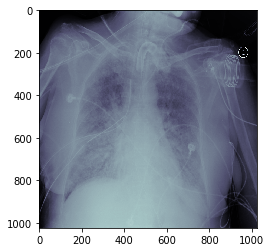

In [6]:
dataset=pydicom.read_file(lstFilesDCM[0])

print()
print("Filename.........:", filename)
print("Storage type.....:", dataset.SOPClassUID)
print()

pat_name = dataset.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name...:", display_name)
print("Patient id.......:", dataset.PatientID)
print("Modality.........:", dataset.Modality)
print("Study Date.......:", dataset.StudyDate)

if 'PixelData' in dataset:
    rows = int(dataset.Rows)
    cols = int(dataset.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dataset.PixelData)))
    if 'PixelSpacing' in dataset:
        print("Pixel spacing....:", dataset.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dataset.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
plt.show()

In [7]:
dataset

(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.8637.1517874338.535924
(0008, 0020) Study Date                          DA: '19010101'
(0008, 0030) Study Time                          TM: '000000.00'
(0008, 0050) Accession Number                    SH: ''
(0008, 0060) Modality                            CS: 'CR'
(0008, 0064) Conversion Type                     CS: 'WSD'
(0008, 0090) Referring Physician's Name          PN: ''
(0008, 103e) Series Description                  LO: 'view: AP'
(0010, 0010) Patient's Name                      PN: '0adec32a-b360-4396-866f-f1abaca047dc'
(0010, 0020) Patient ID                          LO: '0adec32a-b360-4396-866f-f1abaca047dc'
(0010, 0030) Patient's Birth Date                DA: ''
(0010, 0040) Patient's Sex                       CS: 'F'
(0010, 1010) Patient's

In [8]:
dataset.pixel_array.shape

(1024, 1024)

In [9]:
IMG_SIZE = 224
arr_224_224_3 = np.zeros((40,224,224,3))
patimgfin=[]
i=0
for row in lstFilesDCM:
    i=i+1
    patdtl = pydicom.read_file(row)
    #patimgfin.append([patdtl.PatientID,np.stack((resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE)), resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE)), resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE))), axis=-1)])
    patimgfin.append([i,patdtl.PatientID,[resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE)), resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE)), resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE))]])    

C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [10]:
arr_40_224_224_3 =np.zeros((40,224,224,3))
arr_224_224_3 = np.zeros((224,224,3))
i=0
for row in lstFilesDCM:
    patdtl = pydicom.read_file(row)
    arr_224_224_3=np.stack((resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE)), resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE)), resize(patdtl.pixel_array,(IMG_SIZE,IMG_SIZE))), axis=-1).shape
    arr_40_224_224_3[i]=arr_224_224_3
    i=i+1


In [11]:
arr_40_224_224_3.shape

(40, 224, 224, 3)

In [ ]:
#len(patbbsetfin)

In [44]:
#patbbsetfin[0]

['32408669-c137-4e8d-bd62-fe8345b40e73',
 [[273.0, 856.0, 234.0, 101.0],
  [702.0, 801.0, 249.0, 144.0],
  [300.0, 367.0, 226.0, 423.0],
  [706.0, 360.0, 232.0, 238.0]],
 1]

In [18]:
len(newpatarr)

26684

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
cv2.imshow('myimage',dataset.pixel_array)
cv2.waitKey(0)
cv2.displayAllWindows()

#im = dataset.pixel_array #np.array(Image.open('stinkbug.png'), dtype=np.uint8)

# Create figure and axes
#fig,ax = plt.subplots(1)

# Display the image
#ax.imshow(im)

# Create a Rectangle patch
#rect = patches.Rectangle((173.0, 434.0),235.0, 301.0,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
#ax.add_patch(rect)

#plt.show()

#plt.imshow(dataset.pixel_array, cmap=plt.cm.bone)
#plt.rectangle('Position', [173.0, 434.0, 235.0, 301.0], 'EdgeColor', 'red');
#plt.show()

In [78]:
len(dictpatient)

26684

In [90]:
count_0

20672

In [91]:
count_1

6012

In [99]:
count_4_bb

13

In [100]:
count_3_bb

119

In [101]:
count_2_bb

3266

In [104]:
count_1_bb

2614

In [107]:
count_4_bb_fake

0

In [108]:
count_3_bb_fake

0

In [109]:
count_2_bb_fake

0

In [110]:
count_1_bb_fake

2615

In [6]:
dictpatient['0adec32a-b360-4396-866f-f1abaca047dc']

{'bbox': {1: {'x': 173.0, 'y': 434.0, 'width': 235.0, 'height': 301.0},
  2: {'x': 536.0, 'y': 470.0, 'width': 212.0, 'height': 338.0}},
 'target': 1}

In [22]:
patxy=[]
X_train_fin=[]
y_train_fin=[]
X_val_fin=[]
y_val_fin=[]
X_train=[]
y_train=[]
X_val=[]
y_val=[]
i=0
for row in patimgfin:
    i=i+1
    #print(row)
    for row1 in patbbsetfin:
        if row[1] == row1[1]:
            if i < 25:
                X_train.append([row[0], row[2]])
                y_train.append(row1[1])
            else:
                X_val.append([row[0], row[2]])
                y_val.append(row1[1])
#X_train_fin.append(X_train)
#y_train_fin.append(y_train)
#X_val_fin.append(X_val)
#y_val_fin.append(y_val)


In [23]:
len(X_train)

0

In [24]:
len(X_val_fin)

0

In [25]:
len(X_train[0])

IndexError: list index out of range

In [ ]:
X_train[0][1][0]

In [ ]:
X_train[0][0][0][2]

In [ ]:
len(y_train)

In [27]:
from keras.applications.mobilenet import MobileNet

In [28]:
model2 = MobileNet(include_top=False, input_shape=(224, 224, 3), classes=2)
model2.load_weights('mobilenet_1_0_224_tf_no_top.h5', by_name=True)

W0120 21:23:17.996898  3324 deprecation_wrapper.py:119] From C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0120 21:23:18.403700  3324 deprecation_wrapper.py:119] From C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0120 21:23:18.413707  3324 deprecation_wrapper.py:119] From C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0120 21:23:18.463742  3324 deprecation_wrapper.py:119] From C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0120 21:23:18.466746  3324 deprecation_

In [29]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [30]:
for layer in model2.layers:# trainable has to be false in order to freeze the layers
  layer.trainable = False

In [31]:
x = model2.layers[-1].output
x = Dense(1, activation='sigmoid')(x)
newModel=Model(inputs=model2.input, outputs=x)

In [32]:
newModel.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [33]:
adam=Adam(lr=0.01)
newModel.compile(optimizer=adam, loss=binary_crossentropy)

W0120 21:23:34.416554  3324 deprecation_wrapper.py:119] From C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0120 21:23:34.436066  3324 deprecation.py:323] From C:\Users\Lenovo-pc\Anaconda3\lib\site-packages\tensorflow\python\ops\nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [34]:
y_train=np.zeros((40,7,7,1))

In [35]:
y_train.shape

(40, 7, 7, 1)

In [37]:
newModel.fit(arr_40_224_224_3, y_train, batch_size=1,epochs=1)

Epoch 1/1
40/40 [==============================] - 11s 269ms/step - loss: 0.0264


In [ ]:
import pandas as pd

In [ ]:
df_test

In [ ]:
import numpy as np
X = np.empty((4,3))